In [13]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import os,sys
sys.path.append('../')

## Math and dataFrame
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

import matplotlib.pyplot as plt

#ML
from sklearn.model_selection import cross_val_predict, StratifiedKFold, KFold
from sklearn.metrics import log_loss, accuracy_score, f1_score, confusion_matrix
from sklearn.decomposition import NMF, LatentDirichletAllocation


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


train set len  159571
test set len  153164
clean samples 143346
toxic samples 16225


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,dirtyness
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,0


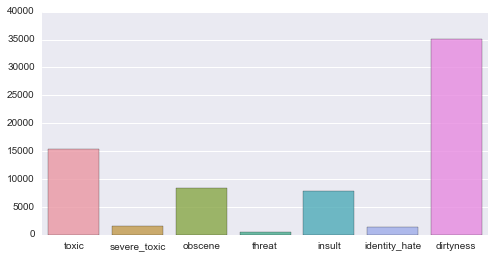

In [3]:
label_cols = ['toxic', 'severe_toxic', 'obscene',  'threat', 'insult', 'identity_hate']

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

train['dirtyness'] = train.apply(lambda x: x.iloc[2::].sum(), axis = 1)
test['dirtyness'] = test.apply(lambda x: x.iloc[2::].sum(), axis = 1)

COMMENT = 'comment_text'
train[COMMENT].fillna("unknown", inplace=True)
test[COMMENT].fillna("unknown", inplace=True)

print("train set len ", len(train) )
print("test set len ", len(test) )
print("clean samples", len(train[train['dirtyness'] == 0]))
print("toxic samples", len(train[train['dirtyness'] != 0]))

x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)

display(train[:10])

In [28]:
# tokenize via tfIdf
from models.FeatureExtraction import FeatureExtraction

fe = FeatureExtraction()
n_feature = None

trn_term_doc = fe.tf(train, n_feature, 'comment_text')
test_term_doc = fe.tf(test, n_feature, 'comment_text')

In [29]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
#cv context
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        raise ValueError("clf NOne")
    
    probas = cross_val_predict(clf, X, y, cv=KFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    print('F1 score: {}'.format(f1_score(y, preds)))
    print( confusion_matrix(y, preds) )
    

In [ ]:
#lda
n_components = 20
n_top_words = 6
#print( LatentDirichletAllocation.__doc__ )
lda = LatentDirichletAllocation(n_topics=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(trn_term_doc)
tf_feature_names = fe.tf_vec.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)



In [ ]:
df_tpc = lda.transform(trn_term_doc)
assert( df_tpc.shape[0] == trn_term_doc.shape[0] )
df_tpc = scipy.sparse.csr_matrix( df_tpc )

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty="l2", dual=True, 
       tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=32, 
       max_iter=100, verbose=0, 
       warm_start=False, n_jobs=1)

for lc in label_cols:
    print("Trainig for {}".format(lc) )
    trn_term_doc_re, label_re = fe.reSample(df_tpc , y = train[lc])
    evaluate_features(trn_term_doc_re, label_re, clf)